In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
import holidays
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context(rc={'figure.figsize':(16,8)})

In [2]:
train = pd.read_csv('E:/DataFiles/LTFS/train.csv')
test = pd.read_csv('E:/DataFiles/LTFS/test.csv')
sample_submission = pd.read_csv('E:/DataFiles/LTFS/sample_submission.csv')

In [3]:
train

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5
2,2017-04-04,1,1.0,WEST BENGAL,EAST,4
3,2017-04-05,1,1.0,WEST BENGAL,EAST,113
4,2017-04-07,1,1.0,WEST BENGAL,EAST,76
...,...,...,...,...,...,...
80397,2019-07-19,2,NaN,WEST BENGAL,NaN,1886
80398,2019-07-20,2,NaN,WEST BENGAL,NaN,1480
80399,2019-07-21,2,NaN,WEST BENGAL,NaN,1028
80400,2019-07-22,2,NaN,WEST BENGAL,NaN,1946


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80402 entries, 0 to 80401
Data columns (total 6 columns):
application_date    80402 non-null object
segment             80402 non-null int64
branch_id           66898 non-null float64
state               80402 non-null object
zone                66898 non-null object
case_count          80402 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 3.7+ MB


In [5]:
train['application_date'] = pd.to_datetime(train['application_date'], format='%Y-%m-%d')
test['application_date'] = pd.to_datetime(test['application_date'], format='%Y-%m-%d')

In [6]:
train['application_date'] = pd.to_datetime(train['application_date'], format='%Y-%m-%d')
train.drop(['branch_id', 'state', 'zone'], axis=1, inplace=True)
train1 = train[train['segment']==1].groupby(['application_date','segment']).sum().reset_index()
train2 = train[train['segment']==2].groupby(['application_date','segment']).sum().reset_index()

In [7]:
testset = test.drop(['id'], axis=1)
test1 = testset[testset['segment']==1].groupby(['application_date','segment']).sum().reset_index()
test2 = testset[testset['segment']==2].groupby(['application_date','segment']).sum().reset_index()

In [8]:
hol = []
for date, name in sorted(holidays.IND(prov='MH', years=[2017, 2018, 2019, 2020]).items()):
    print(date, name)
    hol.append(date)
hol = [pd.to_datetime(i) for i in hol]
hol

2017-01-14 Makar Sankranti / Pongal
2017-01-26 Republic Day
2017-04-14 Dr. B. R. Ambedkar's Jayanti
2017-05-01 Maharashtra Day, Labour Day
2017-08-15 Independence Day
2017-10-02 Gandhi Jayanti
2017-12-25 Christmas
2018-01-14 Makar Sankranti / Pongal
2018-01-26 Republic Day
2018-04-14 Dr. B. R. Ambedkar's Jayanti
2018-05-01 Maharashtra Day, Labour Day
2018-08-15 Independence Day
2018-10-02 Gandhi Jayanti
2018-12-25 Christmas
2019-01-14 Makar Sankranti / Pongal
2019-01-26 Republic Day
2019-04-14 Dr. B. R. Ambedkar's Jayanti
2019-05-01 Maharashtra Day, Labour Day
2019-08-15 Independence Day
2019-10-02 Gandhi Jayanti
2019-12-25 Christmas
2020-01-14 Makar Sankranti / Pongal
2020-01-26 Republic Day
2020-04-14 Dr. B. R. Ambedkar's Jayanti
2020-05-01 Maharashtra Day, Labour Day
2020-08-15 Independence Day
2020-10-02 Gandhi Jayanti
2020-12-25 Christmas


[Timestamp('2017-01-14 00:00:00'),
 Timestamp('2017-01-26 00:00:00'),
 Timestamp('2017-04-14 00:00:00'),
 Timestamp('2017-05-01 00:00:00'),
 Timestamp('2017-08-15 00:00:00'),
 Timestamp('2017-10-02 00:00:00'),
 Timestamp('2017-12-25 00:00:00'),
 Timestamp('2018-01-14 00:00:00'),
 Timestamp('2018-01-26 00:00:00'),
 Timestamp('2018-04-14 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-08-15 00:00:00'),
 Timestamp('2018-10-02 00:00:00'),
 Timestamp('2018-12-25 00:00:00'),
 Timestamp('2019-01-14 00:00:00'),
 Timestamp('2019-01-26 00:00:00'),
 Timestamp('2019-04-14 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-08-15 00:00:00'),
 Timestamp('2019-10-02 00:00:00'),
 Timestamp('2019-12-25 00:00:00'),
 Timestamp('2020-01-14 00:00:00'),
 Timestamp('2020-01-26 00:00:00'),
 Timestamp('2020-04-14 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-08-15 00:00:00'),
 Timestamp('2020-10-02 00:00:00'),
 Timestamp('2020-12-25 00:00:00')]

In [9]:
def add_date_features(df):
    df['year'] = df['application_date'].dt.year
    df['month'] = df['application_date'].dt.month
    df['day'] = df['application_date'].dt.day
    df['week'] = df['application_date'].dt.week
    df['dayofweek'] = df['application_date'].dt.dayofweek
    df['dayofyear'] = df['application_date'].dt.dayofyear
    df['quarter'] = df['application_date'].dt.quarter
    df['is_month_start'] = df['application_date'].dt.is_month_start
    df['is_month_end'] = df['application_date'].dt.is_month_end
    df['is_quarter_start'] = df['application_date'].dt.is_quarter_start
    df['is_quarter_end'] = df['application_date'].dt.is_quarter_end
    df['is_year_start'] = df['application_date'].dt.is_year_start
    df['is_year_end'] = df['application_date'].dt.is_year_end
    df['is_holiday'] = df['application_date'].isin(hol)
    df['semester'] = np.where(df['quarter'].isin([1,2]), 1,2)
    return df

train1 = add_date_features(train1)
train1.drop(['application_date', 'segment'], axis=1, inplace=True)
train2 = add_date_features(train2)
train2.drop(['application_date', 'segment'], axis=1, inplace=True)

test1 = add_date_features(test1)
test1.drop(['application_date', 'segment'], axis=1, inplace=True)
test2 = add_date_features(test2)
test2.drop(['application_date', 'segment'], axis=1, inplace=True)


In [10]:
train1.shape, train2.shape, test.shape

((806, 16), (844, 16), (180, 3))

3.8995773334820756


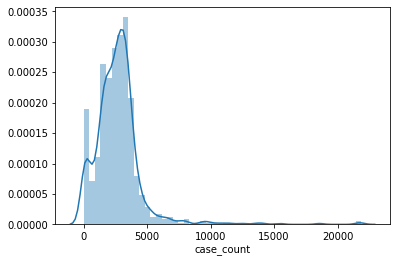

In [11]:
print(train1['case_count'].skew())
sns.distplot(train1['case_count'])

In [12]:
train1_95 = train1[train1['case_count']<train1['case_count'].quantile(0.98)].reset_index(drop=True)
train1_95.shape

(789, 16)

0.31180463975703065


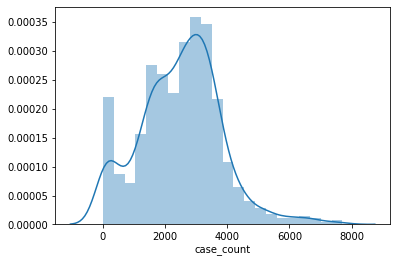

In [13]:
print(train1_95['case_count'].skew())
sns.distplot(train1_95['case_count'])

0.3592138065038034


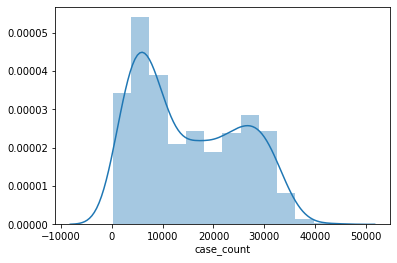

In [14]:
print(train2['case_count'].skew())
sns.distplot(train2['case_count'])

In [15]:
train2_98 = train2[train2['case_count']<train2['case_count'].quantile(0.95)].reset_index(drop=True)
train2_98.shape

(801, 16)

0.3531291733846725


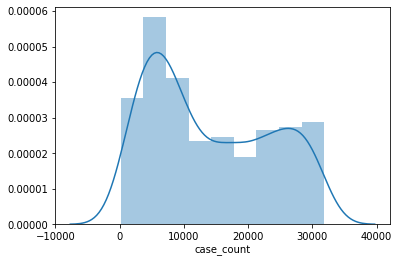

In [16]:
print(train2_98['case_count'].skew())
sns.distplot(train2_98['case_count'])

In [17]:
# train1 = train1_95.copy()
# train2 = train2_98.copy()
train1 = train1[train1['case_count'] > 15].reset_index(drop=True)
train1 = train1[train1['case_count'] <= 8000].reset_index(drop=True)
train2 = train2[train2['case_count'] < 40000].reset_index(drop=True)
train1.shape, train2.shape

((780, 16), (843, 16))

In [18]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true)*100)

## Train Test Split 1

In [19]:
target1 = train1['case_count']
train1.drop(['case_count'], axis=1, inplace=True)

In [20]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(train1, target1, test_size=0.25, random_state=42)
X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

((585, 15), (585,), (195, 15), (195,))

In [21]:
br = BaggingRegressor(random_state=0)
br.fit(X_train1, y_train1)
y_pred1 = br.predict(X_test1)
# print("RMSE: ",mean_squared_error(y_test1, y_pred1, squared=False))
print("MAPE: ",MAPE(y_test1, y_pred1))

MAPE:  287.3896011342917


## Train Test Split 2

In [22]:
target2 = train2['case_count']
train2.drop(['case_count'], axis=1, inplace=True)

In [23]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(train2, target2, test_size=0.25, random_state=42)
X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape

((632, 15), (632,), (211, 15), (211,))

In [24]:
br = BaggingRegressor(random_state=0)
br.fit(X_train2, y_train2)
y_pred2 = br.predict(X_test2)
# print("RMSE: ",mean_squared_error(y_test2, y_pred2, squared=False))
print("MAPE: ",MAPE(y_test2, y_pred2))

MAPE:  23.56483789823521


## Business Segment 1

In [25]:
y_pred_test1 = []
err_all1 = []
for train_index, test_index in KFold(n_splits=15, shuffle=True, random_state=101).split(train1):
    X_train1, X_test1 = train1.loc[train_index], train1.loc[test_index]
    y_train1, y_test1 = target1.loc[train_index], target1.loc[test_index]
    br1 = BaggingRegressor(n_estimators=10, random_state=1)
    br1.fit(X_train1, y_train1)
    y_pred1 = br1.predict(X_test1)
    error1 = MAPE(y_test1, y_pred1)
    err_all1.append(error1)
    print('Mape : ', error1)
    p1 = br1.predict(test1)
    y_pred_test1.append(p1)
print('Average MAPE : ', np.mean(err_all1))  

Mape :  129.6920155259152
Mape :  61.49852926670652
Mape :  86.63891527263576
Mape :  357.45578012011254
Mape :  72.5464676217962
Mape :  86.444508301334
Mape :  84.95542577344699
Mape :  80.96200481558085
Mape :  19.59560152139075
Mape :  132.3282498612436
Mape :  88.53248706299813
Mape :  32.42368600942615
Mape :  59.12206746576454
Mape :  224.20767094890556
Mape :  124.62315325814104
Average MAPE :  109.40177085502653


In [26]:
y_pred_test1_m = np.mean(y_pred_test1, 0)
test1['case_count'] = y_pred_test1_m
test1

,year,month,day,week,dayofweek,dayofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,semester,case_count
0,2019,7,6,27,5,187,3,False,False,False,False,False,False,False,2,2855.666667
1,2019,7,7,27,6,188,3,False,False,False,False,False,False,False,2,1741.900000
2,2019,7,8,28,0,189,3,False,False,False,False,False,False,False,2,4101.073333
3,2019,7,9,28,1,190,3,False,False,False,False,False,False,False,2,3509.800000
4,2019,7,10,28,2,191,3,False,False,False,False,False,False,False,2,3678.080000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2019,9,26,39,3,269,3,False,False,False,False,False,False,False,2,3417.580000
83,2019,9,27,39,4,270,3,False,False,False,False,False,False,False,2,3450.440000
84,2019,9,28,39,5,271,3,False,False,False,False,False,False,False,2,3050.960000
85,2019,9,29,39,6,272,3,False,False,False,False,False,False,False,2,2544.380000


## Business Segment 2

In [27]:
y_pred_test2 = []
err_all2 = []
for train_index, test_index in KFold(n_splits=15, shuffle=True, random_state=101).split(train2):
    X_train2, X_test2 = train2.loc[train_index], train2.loc[test_index]
    y_train2, y_test2 = target2.loc[train_index], target2.loc[test_index]
    br2 = BaggingRegressor(random_state=101)
    br2.fit(X_train2, y_train2)
    y_pred2 = br2.predict(X_test2)
    error2 = MAPE(y_test2, y_pred2)
    err_all2.append(error2)
    print('Mape : ', error2)
    p2 = br2.predict(test2)
    y_pred_test2.append(p2)
print('Average MAPE : ', np.mean(err_all2))

Mape :  27.926729008677317
Mape :  21.660276860397985
Mape :  80.61689593806183
Mape :  20.902094950657055
Mape :  23.787064739395102
Mape :  25.99944745333276
Mape :  19.5784546847494
Mape :  20.306029903446454
Mape :  18.433480143374954
Mape :  16.452121637992313
Mape :  31.522039255925726
Mape :  21.792441534841423
Mape :  18.866010096383636
Mape :  20.866716979686736
Mape :  23.778566112322274
Average MAPE :  26.16589128661633


In [28]:
y_pred_test2_m = np.mean(y_pred_test2, 0)
test2['case_count'] = y_pred_test2_m
test2

,year,month,day,week,dayofweek,dayofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_holiday,semester,case_count
0,2019,7,24,30,2,205,3,False,False,False,False,False,False,False,2,27071.426667
1,2019,7,25,30,3,206,3,False,False,False,False,False,False,False,2,26214.946667
2,2019,7,26,30,4,207,3,False,False,False,False,False,False,False,2,24750.640000
3,2019,7,27,30,5,208,3,False,False,False,False,False,False,False,2,22669.900000
4,2019,7,28,30,6,209,3,False,False,False,False,False,False,False,2,17053.086667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2019,10,20,42,6,293,4,False,False,False,False,False,False,False,2,16117.073333
89,2019,10,21,43,0,294,4,False,False,False,False,False,False,False,2,22843.113333
90,2019,10,22,43,1,295,4,False,False,False,False,False,False,False,2,26887.820000
91,2019,10,23,43,2,296,4,False,False,False,False,False,False,False,2,28374.933333


In [29]:
test['case_count'] = np.concatenate((y_pred_test1_m, y_pred_test2_m))
test

,id,application_date,segment,case_count
0,1,2019-07-06,1,2855.666667
1,2,2019-07-07,1,1741.900000
2,3,2019-07-08,1,4101.073333
3,4,2019-07-09,1,3509.800000
4,5,2019-07-10,1,3678.080000
...,...,...,...,...
175,176,2019-10-20,2,16117.073333
176,177,2019-10-21,2,22843.113333
177,178,2019-10-22,2,26887.820000
178,179,2019-10-23,2,28374.933333


In [30]:
from IPython.display import HTML
import base64
def create_download_link(df, title='Download Submission File', filename='MySubmission.csv'):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload, title=title, filename=filename)
    return HTML(html)
create_download_link(test)